<a href="https://colab.research.google.com/github/Mvgrillo1357/Ai-Platform-Engineering/blob/master/Predictive_Geographic_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Personal Project

In [0]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install kaggle

In [0]:
!mkdir .kaggle
!mkdir ~/.kaggle

In [0]:
import json
token = {"username":"michaelgrillo","key":"1b1b61b21b7bd669c2b170bf718b9cd8"}
with open ('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(token, file)

In [0]:
!chmod 600 /content/.kaggle/kaggle.json

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [0]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!kaggle datasets download -d sobhanmoosavi/us-accidents -p /content --force

 97% 193M/199M [00:04<00:00, 52.2MB/s]
100% 199M/199M [00:04<00:00, 47.1MB/s]


In [0]:
!unzip \*.zip

Archive:  us-accidents.zip
  inflating: US_Accidents_Dec19.csv  


In [0]:
!ls

sample_data  US_Accidents_Dec19.csv  us-accidents.zip


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import scipy as sp
!pip install geopandas
import sklearn as skl
import geopandas as gpd
import geopy
import folium
from shapely.geometry import Point, Polygon
from sklearn.cluster import KMeans
from shapely.ops import nearest_points
from geopy.geocoders import Nominatim
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, mean_squared_error
from collections import Counter
from sklearn.datasets import make_classification
!pip install imblearn
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import pickle

In [0]:
import io
df_traffic = pd.read_csv('US_Accidents_Dec19.csv')


For my personal individual project I would like to use machine learning in order to find trends over an extensive dataset which documents all traffic violations in 49 states of the United States collected from February 2016 to December 2019. The data set used was gathered from https://www.kaggle.com/sobhanmoosavi/us-accidents. By deploying a machine learning model that can predict trends and categorize variables I will be able be able to make predictive geographic clustering.

https://smoosavi.org/datasets/us_accidents
    this link defines the various variables of the dataset. This dataset is a live document but I used the data that lasted from February 2016 to December 2019.

In [0]:
df_traffic.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,I-70 E,R,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,2584.0,Brice Rd,L,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,Accident on OH-32 State Route 32 Westbound at ...,NaN,State Route 32,R,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,I-75 S,R,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,NaN,Miamisburg Centerville Rd,R,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day


In [0]:
df_traffic.describe()

,TMC,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Number,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,2.246264e+06,2.974335e+06,2.974335e+06,2.974335e+06,728071.000000,728071.000000,2.974335e+06,1.056730e+06,2.918272e+06,1.121712e+06,2.915162e+06,2.926193e+06,2.908644e+06,2.533495e+06,975977.000000
mean,2.078316e+02,2.360190e+00,3.649361e+01,-9.542625e+01,37.580871,-99.976032,2.855654e-01,5.837004e+03,6.235120e+01,5.132685e+01,6.540542e+01,2.983190e+01,9.150770e+00,8.298064e+00,0.020495
std,2.032959e+01,5.414733e-01,4.918849e+00,1.721881e+01,5.004757,18.416647,1.548392e+00,1.515928e+04,1.878855e+01,2.519127e+01,2.255676e+01,7.213808e-01,2.892114e+00,5.138546e+00,0.235770
min,2.000000e+02,1.000000e+00,2.455527e+01,-1.246238e+02,24.570110,-124.497829,0.000000e+00,0.000000e+00,-7.780000e+01,-6.590000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,2.010000e+02,2.000000e+00,3.355040e+01,-1.172920e+02,33.957554,-118.286610,0.000000e+00,8.370000e+02,5.000000e+01,3.200000e+01,4.900000e+01,2.982000e+01,1.000000e+01,4.600000e+00,0.000000
50%,2.010000e+02,2.000000e+00,3.584969e+01,-9.025083e+01,37.903670,-96.631690,0.000000e+00,2.717000e+03,6.440000e+01,5.400000e+01,6.700000e+01,2.998000e+01,1.000000e+01,7.000000e+00,0.000000
75%,2.010000e+02,3.000000e+00,4.037026e+01,-8.091891e+01,41.372630,-82.323850,1.000000e-02,7.000000e+03,7.600000e+01,7.300000e+01,8.400000e+01,3.011000e+01,1.000000e+01,1.040000e+01,0.000000
max,4.060000e+02,4.000000e+00,4.900220e+01,-6.711317e+01,49.075000,-67.109242,3.336300e+02,9.999997e+06,1.706000e+02,1.150000e+02,1.000000e+02,3.304000e+01,1.400000e+02,8.228000e+02,25.000000


In [0]:
df_traffic.columns

Index(['ID', 'Source', 'TMC', 'Severity', 'Start_Time', 'End_Time',
       'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)',
       'Description', 'Number', 'Street', 'Side', 'City', 'County', 'State',
       'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
       'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

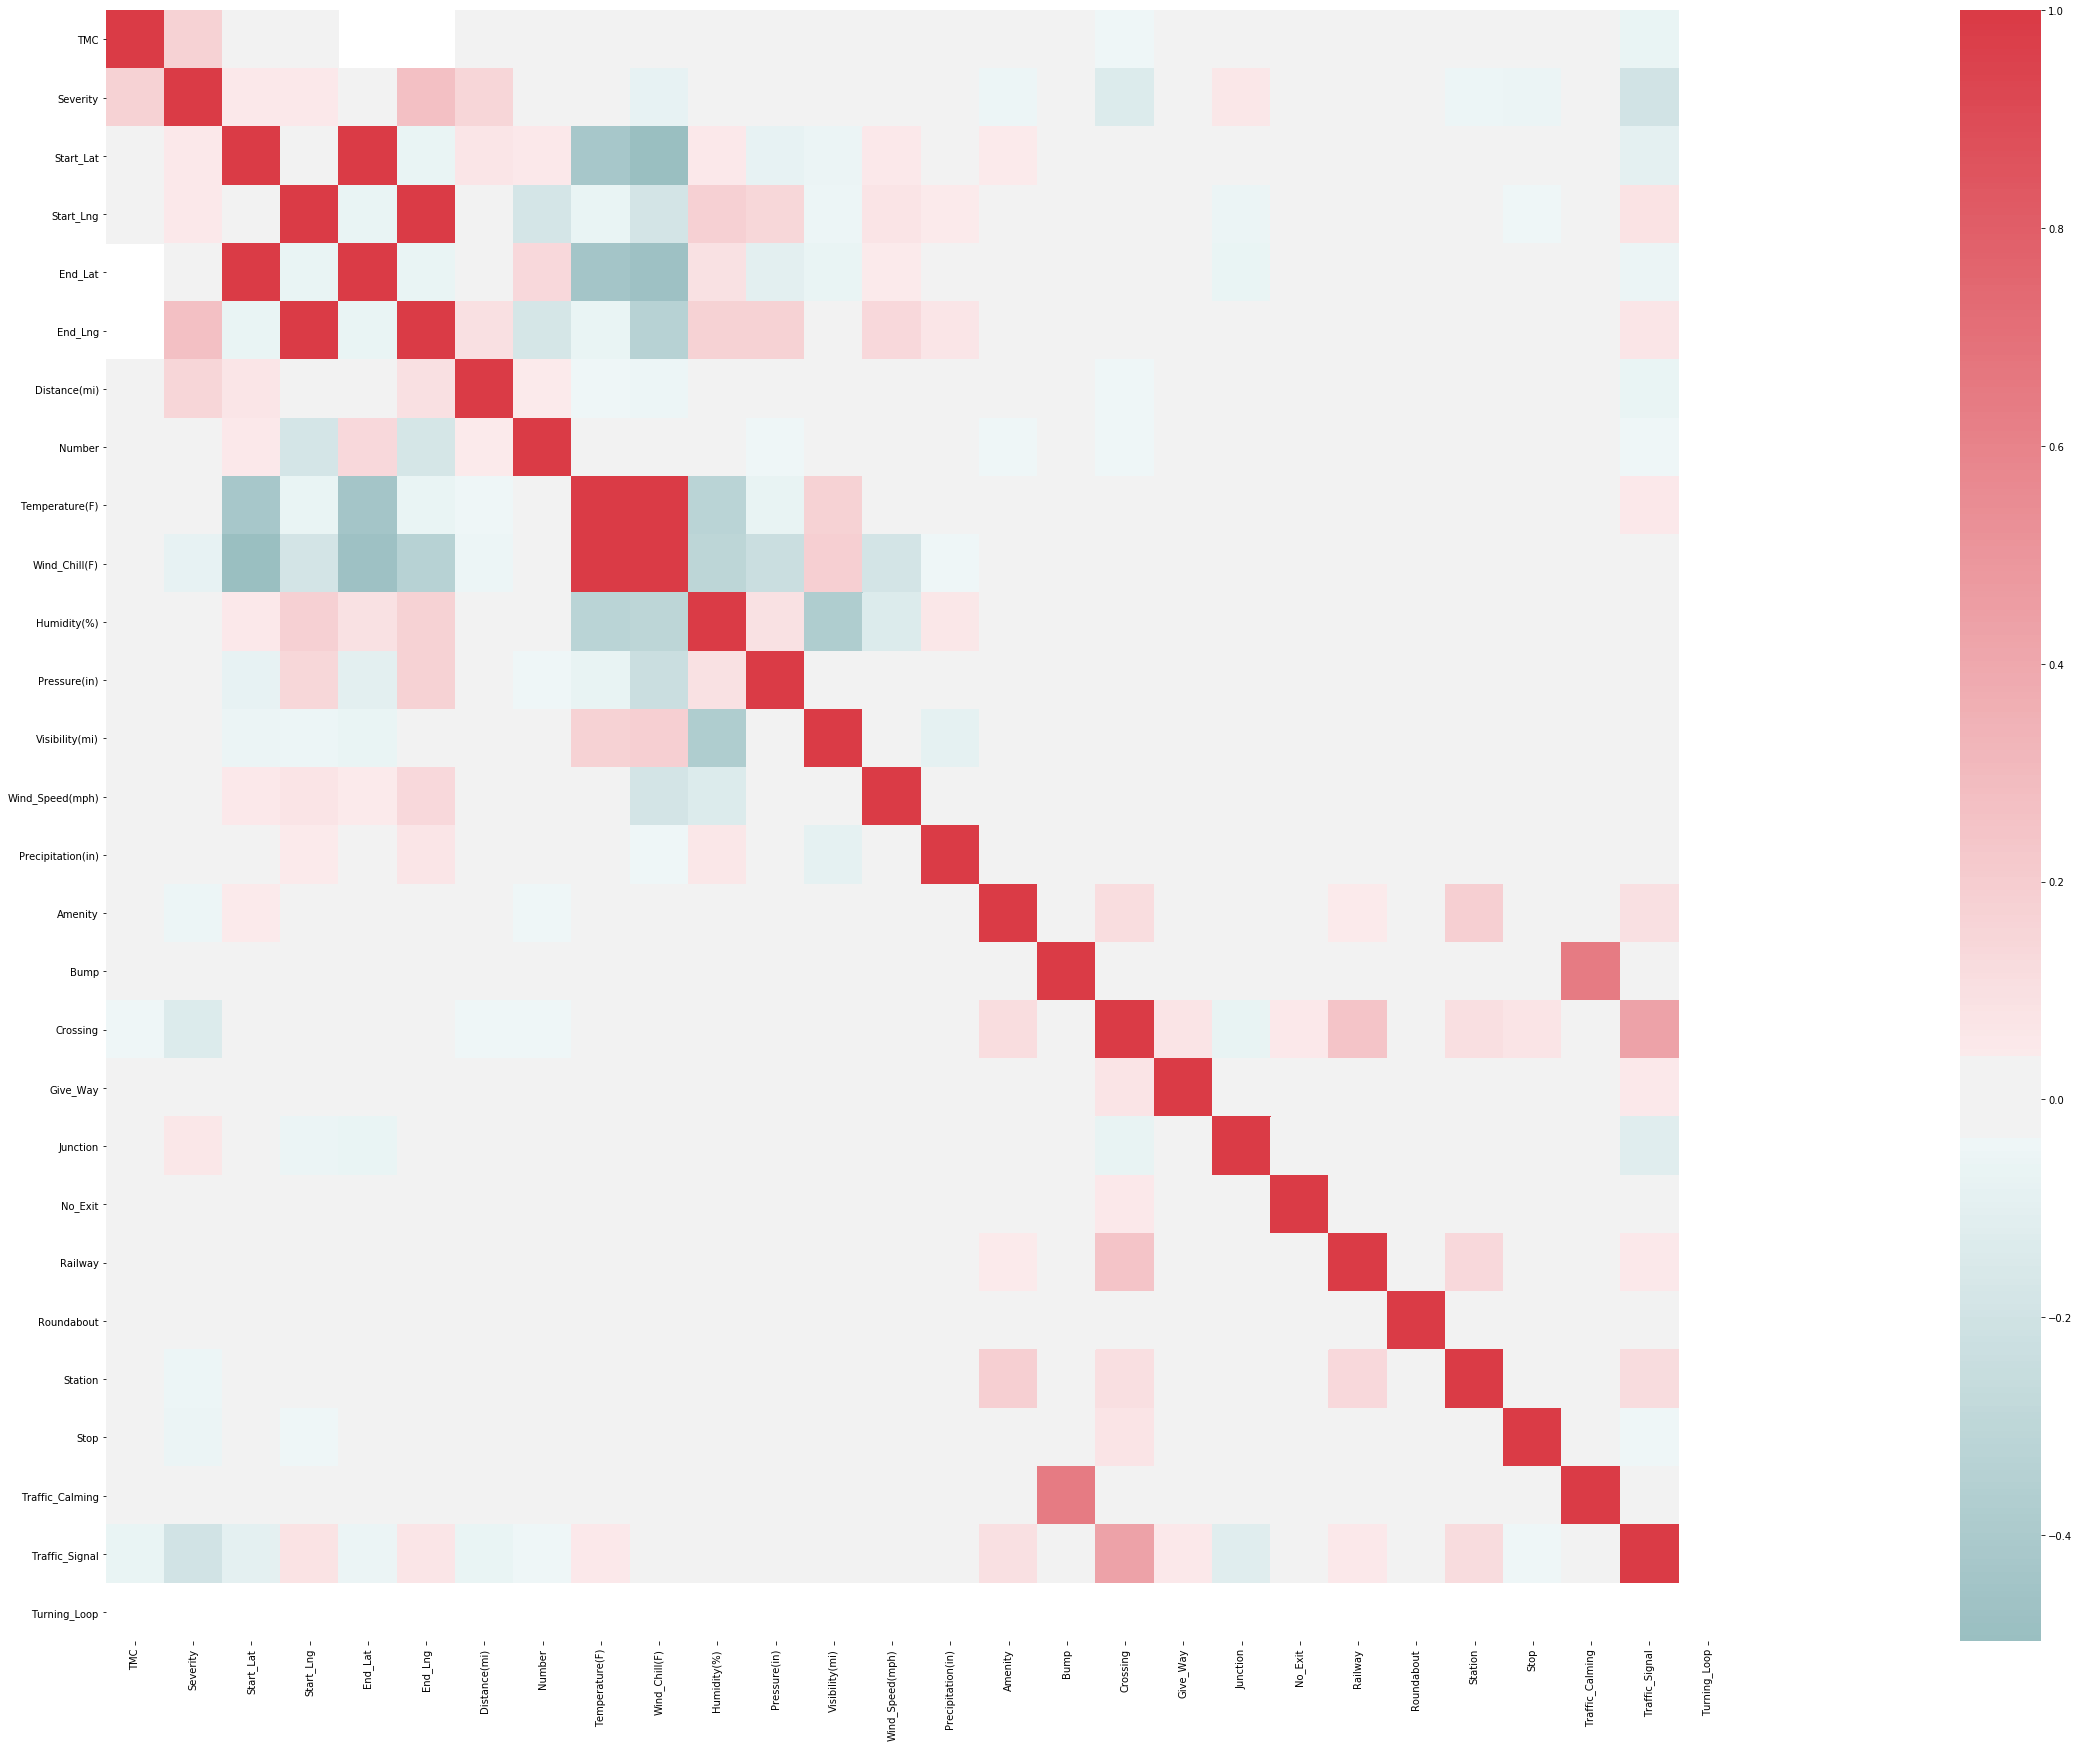

In [0]:
corr=df_traffic.corr()
cmap = sns.diverging_palette(200, 10, as_cmap=True)

size=plt.figure(figsize=(80,30))

sns.heatmap(corr, cmap=cmap, square='true', center=0)

In [0]:
print('Unique values',df_traffic.nunique())

Unique values ID                       2974335
Source                         3
TMC                           21
Severity                       4
Start_Time               2743101
End_Time                 2761499
Start_Lat                1002359
Start_Lng                 985099
End_Lat                   298605
End_Lng                   302906
Distance(mi)               12847
Description              1597506
Number                     37398
Street                    160715
Side                           3
City                       11685
County                      1713
State                         49
Zipcode                   377152
Country                        1
Timezone                       4
Airport_Code                1995
Weather_Timestamp         470781
Temperature(F)               827
Wind_Chill(F)                971
Humidity(%)                  100
Pressure(in)                 994
Visibility(mi)                81
Wind_Direction                24
Wind_Speed(mph)              

This data is only for the United States so keeping the 'Country' column is 100% redundant.

In [0]:
df_traffic.drop(['Country'], axis=1, inplace=True)

In [0]:
print(df_traffic.isnull().sum())


ID                             0
Source                         0
TMC                       728071
Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                  2246264
End_Lng                  2246264
Distance(mi)                   0
Description                    1
Number                   1917605
Street                         0
Side                           0
City                          83
County                         0
State                          0
Zipcode                      880
Timezone                    3163
Airport_Code                5691
Weather_Timestamp          36705
Temperature(F)             56063
Wind_Chill(F)            1852623
Humidity(%)                59173
Pressure(in)               48142
Visibility(mi)             65691
Wind_Direction             45101
Wind_Speed(mph)           440840
Precipitation(in)        1998358
Weather_Co

In [0]:
print(len(df_traffic['End_Lat']))
print(len(df_traffic['End_Lng']))

2974335
2974335


In [0]:
print(len(df_traffic['End_Lat'].isnull())/(len(df_traffic['End_Lat'])))
print(len(df_traffic['End_Lng'].isnull())/(len(df_traffic['End_Lat'])))

1.0
1.0


The 'End_Lat' and 'End_Lng' are all null values so they need to be dropped.

In [0]:
df_traffic.drop(['End_Lat'], axis=1, inplace=True)
df_traffic.drop(['End_Lng'], axis=1, inplace=True)

Since the data involves over 2 million accidents it is important to target States of interest. In my case I am looking for the state with the most accidents, the state with the most category 4 accidents and the state with the highest on average (mean) severity of accidents.

In [0]:
whichstate=df_traffic.State.unique()

count_state=[]
for i in df_traffic.State.unique():
    count_state.append(df_traffic[df_traffic['State']==i].count()['ID'])


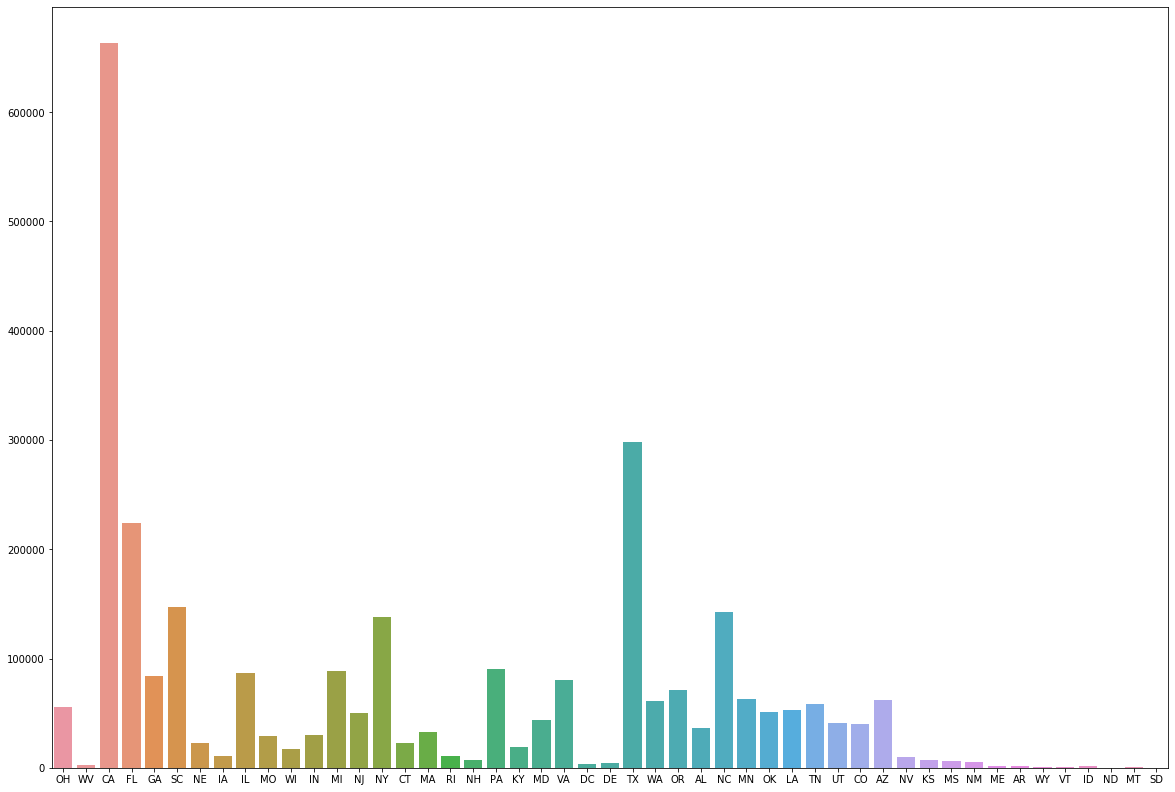

In [0]:
plt.figure(figsize=(20, 14))
sns.barplot(whichstate, count_state)

Excellent, california is definetely a state of interest. Next we will look at the mean of the severity of the accident that the individual States experience. 

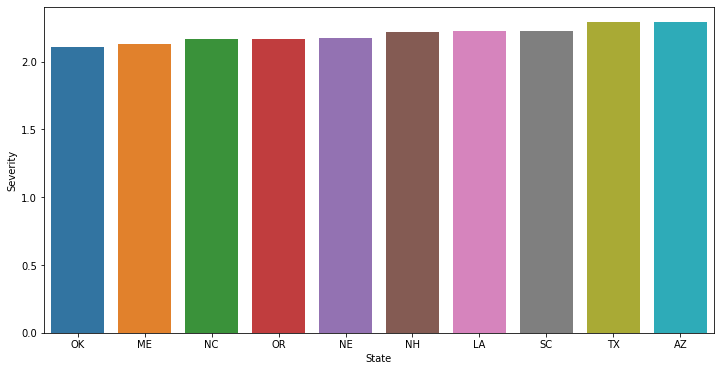

In [0]:
df_top_Severity_State = df_traffic.groupby('State').agg({'Severity': 'mean'}).sort_values('Severity').reset_index()
plt.figure(figsize=(12,6))
sns.barplot(y="Severity", x="State", data=df_top_Severity_State.head(10))
plt.ioff()

Arizona is definitely a state of interest. Texas is also a state of interest since Texas has a large number of accidents and yet it's mean is still in second place.

In [0]:
severity_4=[]
for i in whichstate:
    severity_4.append(df_traffic[(df_traffic['Severity']==4)&(df_traffic['State']==i)].count()['ID'])

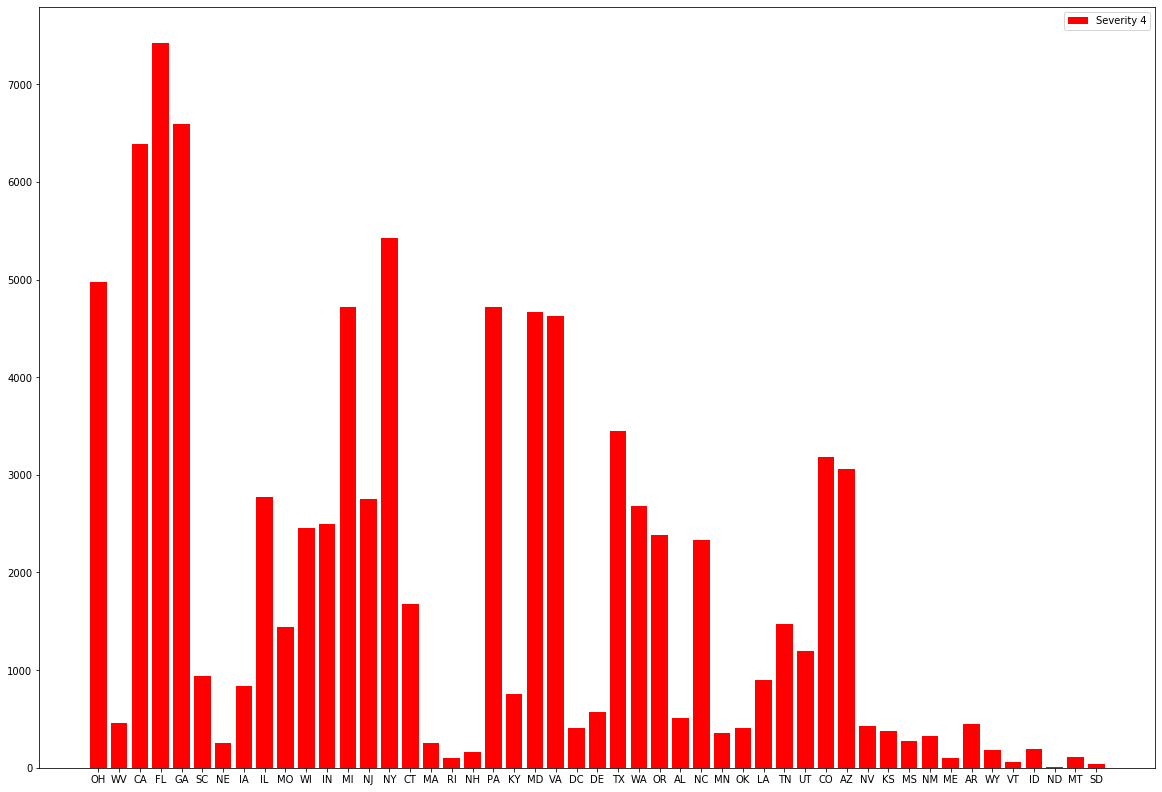

In [0]:
plt.figure(figsize=(20, 14))
plt.bar(whichstate, severity_4, label= 'Severity 4', color= 'red')
plt.legend()

From my analysis, Florida may not have the most accidents but it certainely has the most severe accidents. Of note Georgia has the second highest number of severity four accidents so therefore Georgia is also a state of interest. Let's check to see if different features are correllated with eachother.

In [0]:
df_traffic.shape

(2974335, 46)

In [0]:
"""
since we have longitude and latitude we do not need number, street, county, zipcode. State and city will be useful for finding our target states to analyze and the city variable is nice to 
map out a centroid of each city and the differences between accidents and centers of the centroids. If we are not given longitude and latitude we can use geocaching in the geopy library to
find the longitude and latitude needed for our model to make a prediction.
"""
df_traffic.drop(['Number'], axis=1, inplace=True)
df_traffic.drop(['Street'], axis=1, inplace=True)
df_traffic.drop(['County'], axis=1, inplace=True)
df_traffic.drop(['Zipcode'], axis=1, inplace=True)

df_traffic.shape

(2974335, 42)

In [0]:
df_traffic.columns

Index(['ID', 'Source', 'TMC', 'Severity', 'Start_Time', 'End_Time',
       'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Description', 'Side', 'City',
       'State', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
       'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

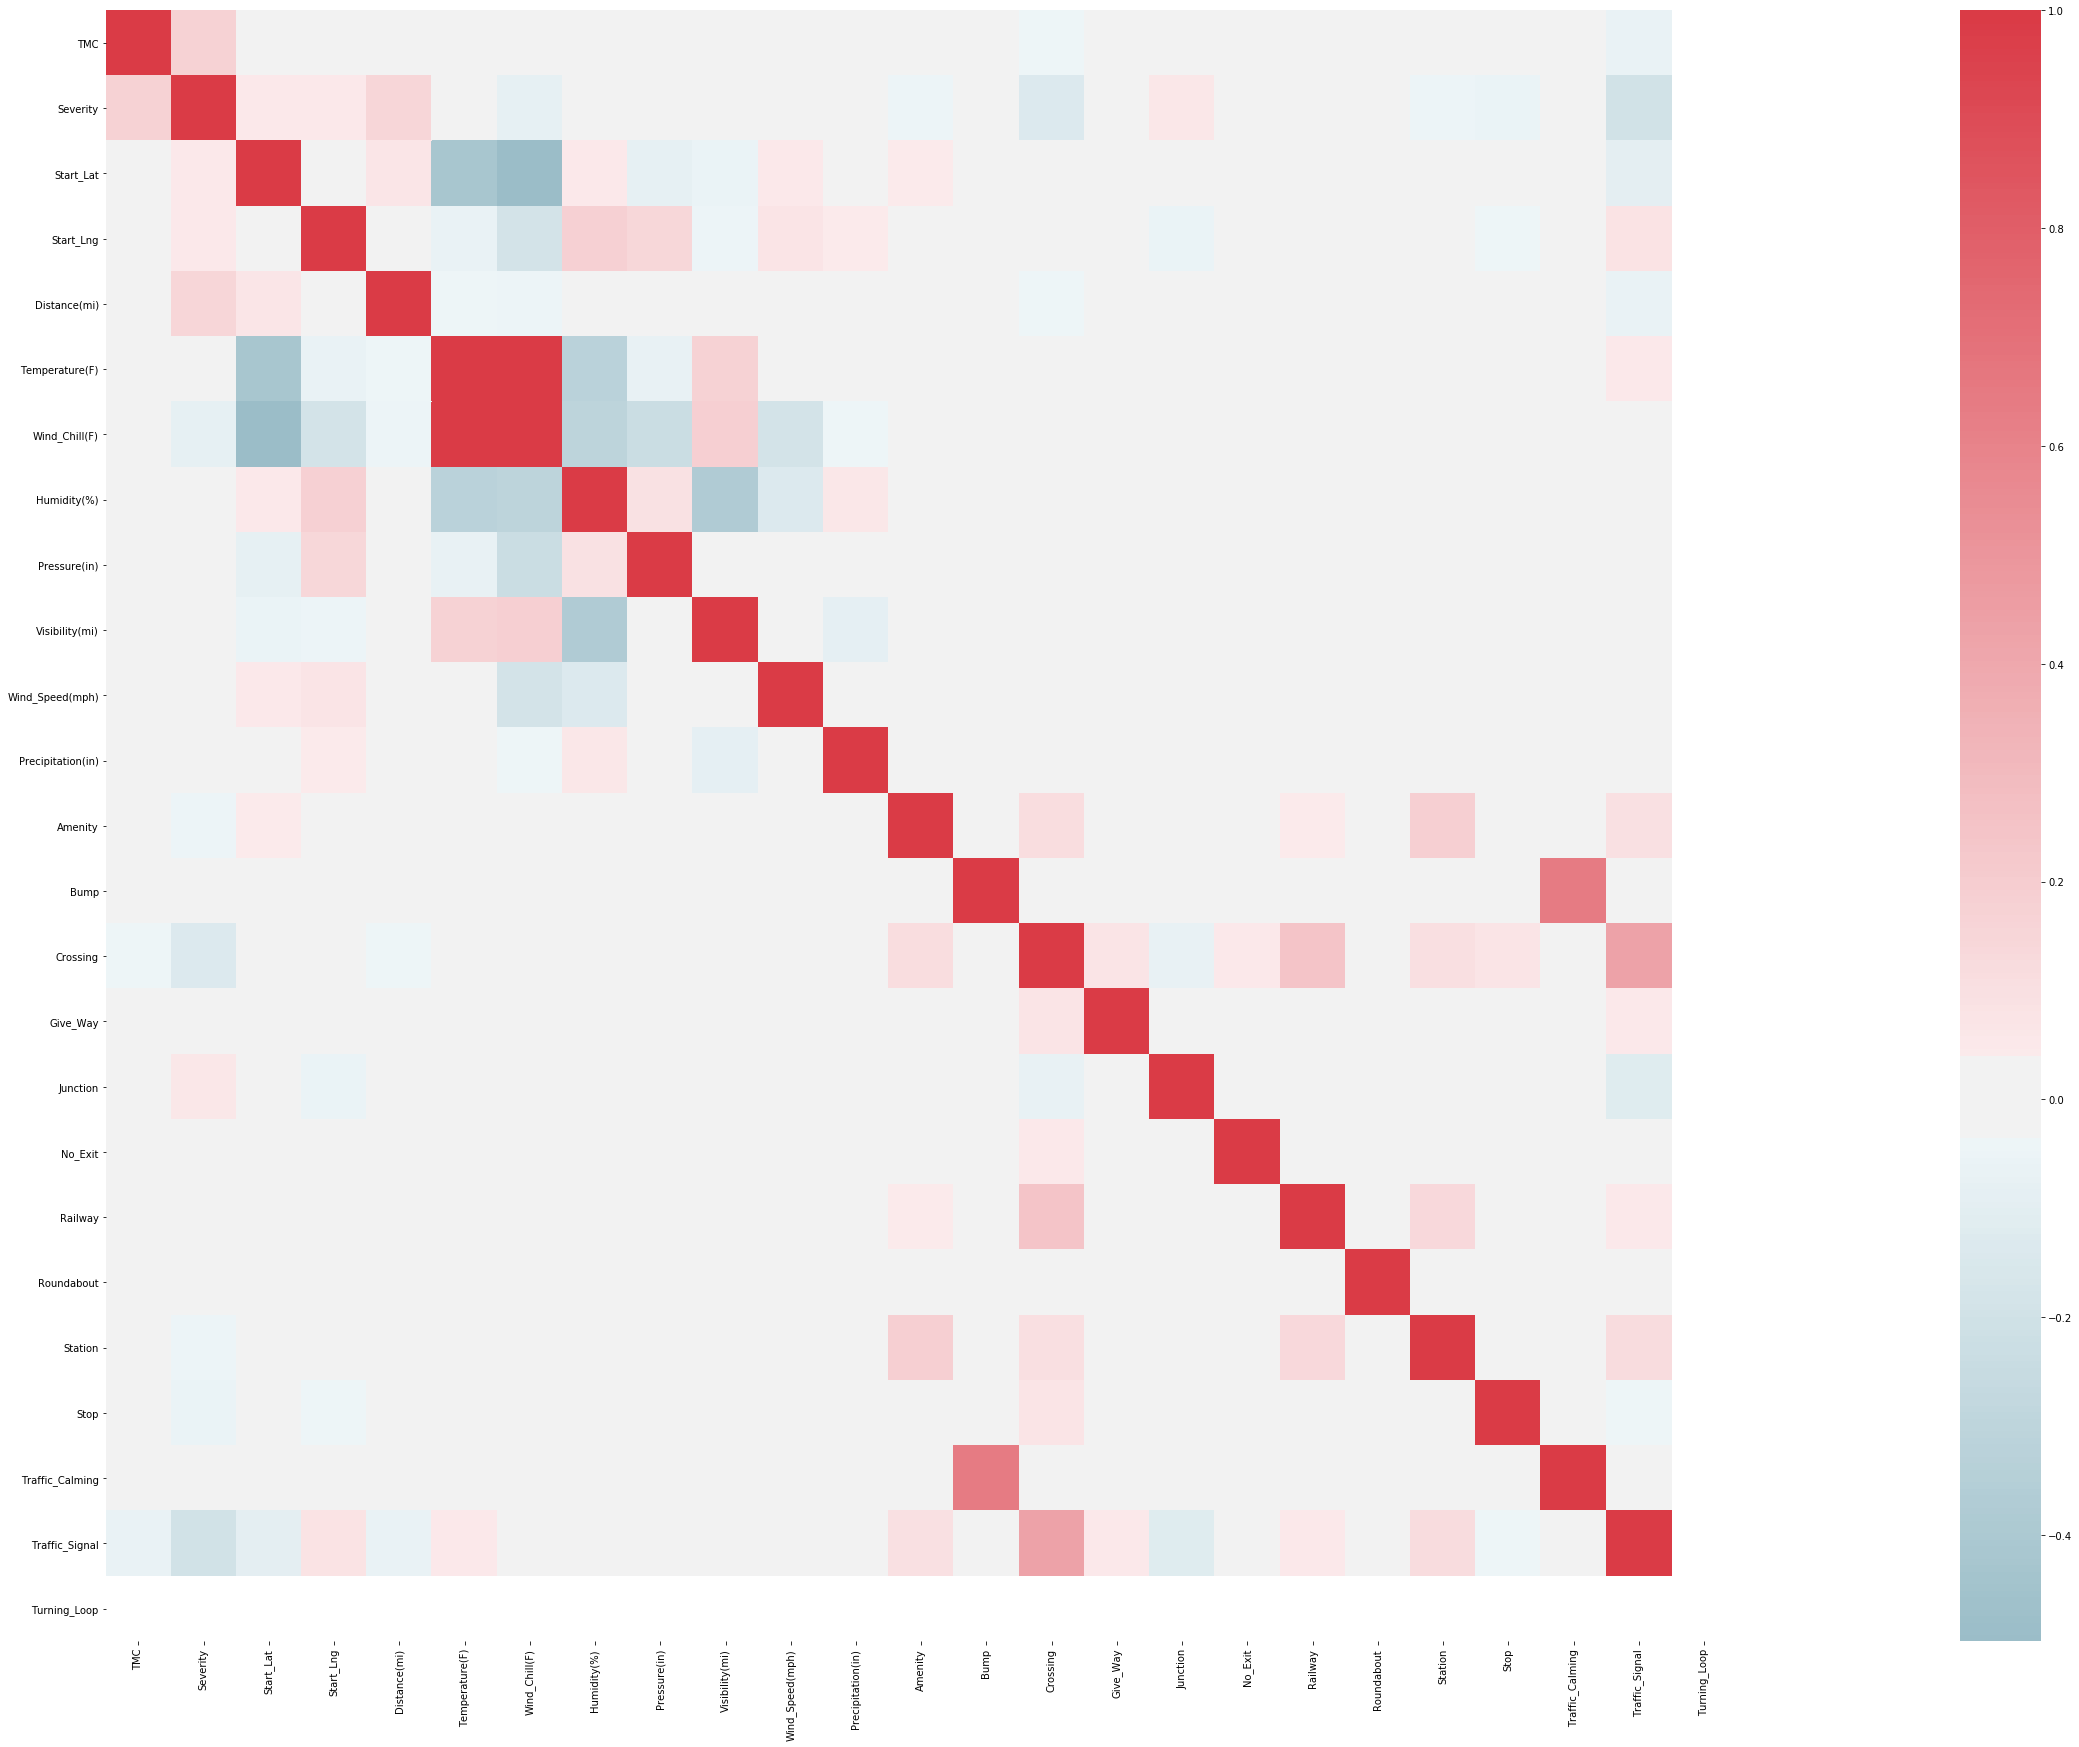

In [0]:
#lets check numerical correlation to see what our results are
corr=df_traffic.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)

size=plt.figure(figsize=(80,30))

sns.heatmap(corr, cmap=cmap, square='true', center=0)

It looks like TMC, Start Lat, Start Lng, Distance, Wind Chill, Amenity, Crossing, Junction, Station, Stop, and Traffic Signal all have some level of correllation with Severity. 

In [0]:
bool_col= [col for col in df_traffic.columns if df_traffic[col].dtype ==np.dtype('bool')]
booldf= df_traffic[bool_col]
not_one_hot= booldf[booldf.sum(axis=1)>1]
accidentlocation=booldf.sum(axis=0)


In [0]:
accidentlocation

Amenity             35220
Bump                  454
Crossing           207590
Give_Way             7627
Junction           238447
No_Exit              3395
Railway             25161
Roundabout            168
Station             56413
Stop                40160
Traffic_Calming      1111
Traffic_Signal     503383
Turning_Loop            0
dtype: int64

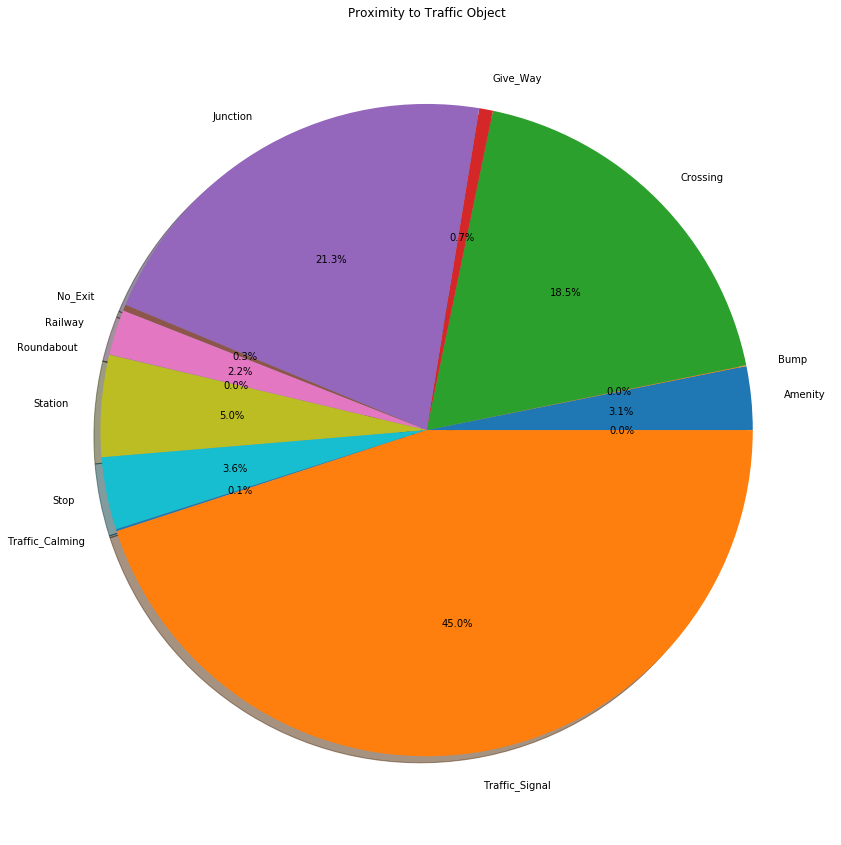

In [0]:
accidentlocation.plot.pie(autopct='%1.1f%%', shadow=True, figsize=(15,15))
plt.ylabel('')
plt.title('Proximity to Traffic Object');

Now that we have examined common occurences and trends within the accident data it is time to look at the data in terms of time series.

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html
Datetime is useful for handling time series data

In [0]:
df_traffic['time'] = pd.to_datetime(df_traffic.Start_Time, format='%Y-%m-%d')
df_traffic = df_traffic.set_index('time')
df_traffic.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Side,City,State,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-02-08 05:46:00,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,0.01,Right lane blocked due to accident on I-70 Eas...,R,Dayton,OH,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
2016-02-08 06:07:59,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,L,Reynoldsburg,OH,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day
2016-02-08 06:49:27,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,0.01,Accident on OH-32 State Route 32 Westbound at ...,R,Williamsburg,OH,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
2016-02-08 07:23:34,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,R,Dayton,OH,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day
2016-02-08 07:39:07,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,R,Dayton,OH,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day


In [0]:
df_traffic.isnull().sum()

ID                             0
Source                         0
TMC                       728071
Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
Distance(mi)                   0
Description                    1
Side                           0
City                          83
State                          0
Timezone                    3163
Airport_Code                5691
Weather_Timestamp          36705
Temperature(F)             56063
Wind_Chill(F)            1852623
Humidity(%)                59173
Pressure(in)               48142
Visibility(mi)             65691
Wind_Direction             45101
Wind_Speed(mph)           440840
Precipitation(in)        1998358
Weather_Condition          65932
Amenity                        0
Bump                           0
Crossing                       0
Give_Way                       0
Junction                       0
No_Exit   

Now we can look at the geographic data by utilizing the geopandas library.

In [0]:
df_florida= df_traffic.loc[(df_traffic['State']=='FL')][['ID', 'Start_Lat', 'Start_Lng', 'Severity']]
df_florida.head()

,ID,Start_Lat,Start_Lng,Severity
time,,,,
2016-11-30 15:36:03,A-116062,27.981367,-82.326561,3
2016-11-30 16:25:35,A-116063,27.981367,-82.326561,3
2016-11-30 16:40:31,A-116064,25.627699,-80.374451,2
2016-11-30 16:34:57,A-116065,25.899435,-80.346680,3
2016-11-30 16:38:41,A-116066,26.272926,-80.296432,2


In [0]:
df_florida.shape

(223746, 4)

In [0]:
def create_gdf(df_florida, lat, lon):
    """ Convert pandas dataframe into a Geopandas GeoDataFrame"""
    crs = {'init': 'epsg:4326'}
    geometry = [Point(xy) for xy in zip(df_florida['Start_Lng'], df_florida['Start_Lat'])]
    gdf = gpd.GeoDataFrame(df_florida, crs= crs , geometry=geometry)
    return gdf
fl_gdf =  create_gdf(df_florida, "latitude", "longitude")
fl_gdf.tail()

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


,ID,Start_Lat,Start_Lng,Severity,geometry
time,,,,,
2019-08-23 14:16:20,A-2974027,26.84352,-80.10460,2,POINT (-80.10460 26.84352)
2019-08-23 14:12:39,A-2974028,29.40633,-81.15644,3,POINT (-81.15644 29.40633)
2019-08-23 17:28:24,A-2974033,27.96509,-82.44727,4,POINT (-82.44727 27.96509)
2019-08-23 19:51:27,A-2974038,28.54708,-81.27017,4,POINT (-81.27017 28.54708)
2019-08-23 19:14:05,A-2974039,25.93595,-80.19918,4,POINT (-80.19918 25.93595)


With a geopandas dataframe we can potentially create a centroid or cluster with K means clustering.

In [0]:
"""
map1 = folium.Map(
    location=[27.6648, -81.5158],
    tiles='cartodbpositron',
    zoom_start=8,
)
fl_gdf.apply(lambda row:folium.CircleMarker(location=[row["Start_Lat"], row["Start_Lng"]]).add_to(map1), axis=1)
map1
"""

'\nmap1 = folium.Map(\n    location=[27.6648, -81.5158],\n    tiles=\'cartodbpositron\',\n    zoom_start=8,\n)\nfl_gdf.apply(lambda row:folium.CircleMarker(location=[row["Start_Lat"], row["Start_Lng"]]).add_to(map1), axis=1)\nmap1\n'

In [0]:
df_floridatrain= df_traffic.loc[(df_traffic['State']=='FL')&(df_traffic['Severity']==4)][['ID', 'Start_Lat', 'Start_Lng']]
df_floridatrain.shape

(7422, 3)

In [0]:
# creates 100 clusters using k-means clustering algorithm.
kmeans = KMeans(n_clusters=100)
clusters = kmeans.fit_predict(df_floridatrain[['Start_Lat','Start_Lng']])


In [0]:
df_floridatrain['cluster'] = kmeans.predict(df_floridatrain[['Start_Lat','Start_Lng']])
df_floridatrain.shape

(7422, 4)

Now that we have some clusters it is ideal if we plot the worst accidents with their clusters.

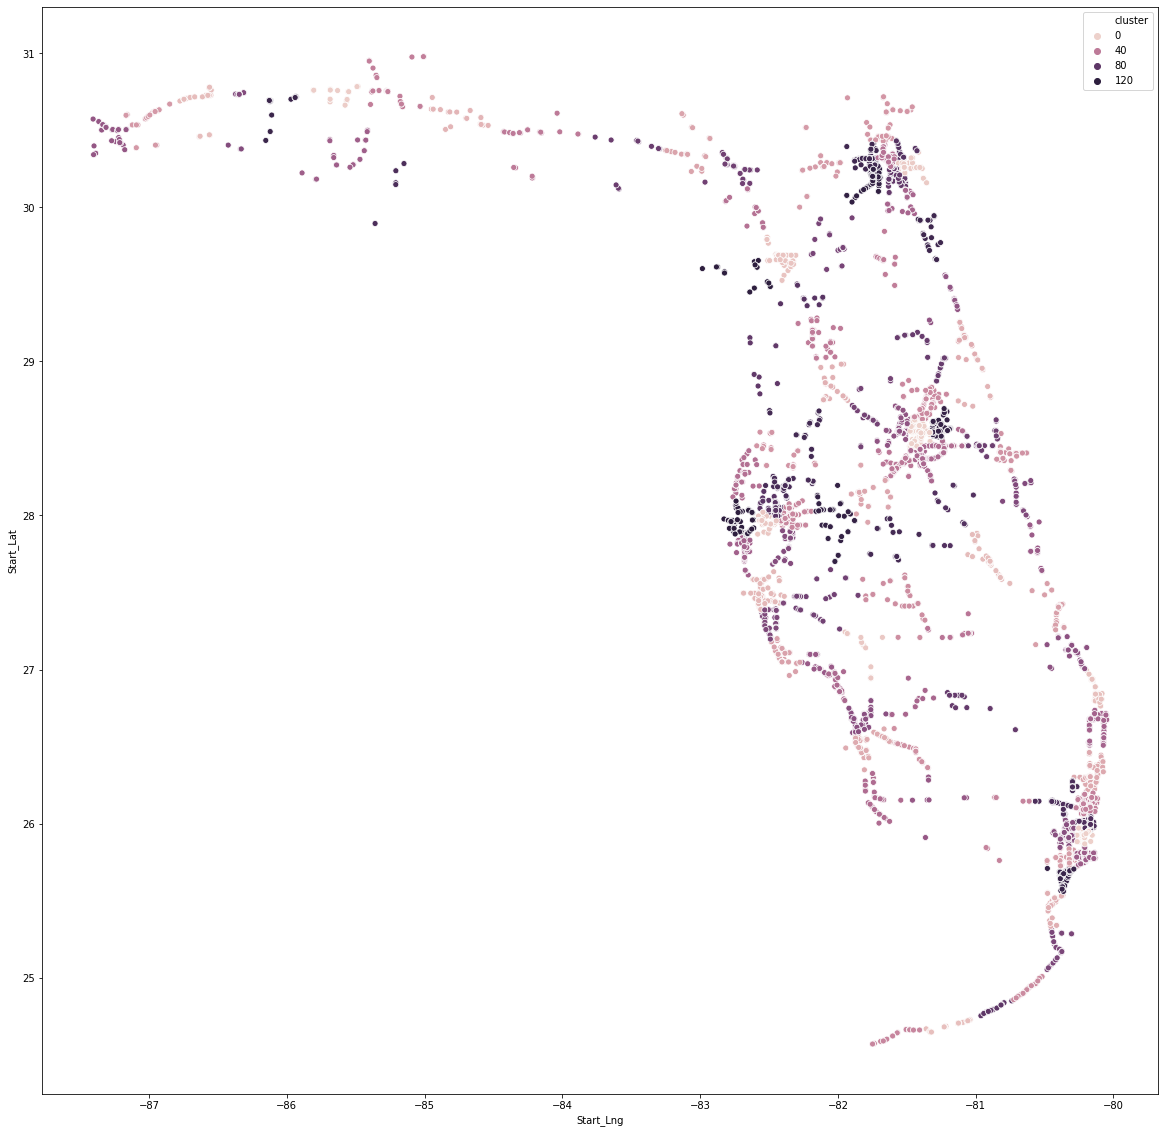

In [0]:
plt.figure(figsize = (20,20))
sns.scatterplot(df_floridatrain['Start_Lng'], df_floridatrain['Start_Lat'], hue=df_floridatrain['cluster'])

In [0]:
def create_gdf(df_floridatrain, lat, lon):
    """ Convert pandas dataframe into a Geopandas GeoDataFrame"""
    crs = {'init': 'epsg:4326'}
    geometry = [Point(xy) for xy in zip(df_floridatrain['Start_Lng'], df_floridatrain['Start_Lat'])]
    gdf2 = gpd.GeoDataFrame(df_floridatrain, crs= crs , geometry=geometry)
    return gdf2
fl_gdf2 =  create_gdf(df_floridatrain, "latitude", "longitude")
fl_gdf2.tail()

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


,ID,Start_Lat,Start_Lng,cluster,geometry
time,,,,,
2019-08-23 10:18:28,A-2974019,27.703600,-80.895270,10,POINT (-80.89527 27.70360)
2019-08-23 13:32:30,A-2974026,30.328189,-82.959449,20,POINT (-82.95945 30.32819)
2019-08-23 17:28:24,A-2974033,27.965090,-82.447270,5,POINT (-82.44727 27.96509)
2019-08-23 19:51:27,A-2974038,28.547080,-81.270170,95,POINT (-81.27017 28.54708)
2019-08-23 19:14:05,A-2974039,25.935950,-80.199180,1,POINT (-80.19918 25.93595)


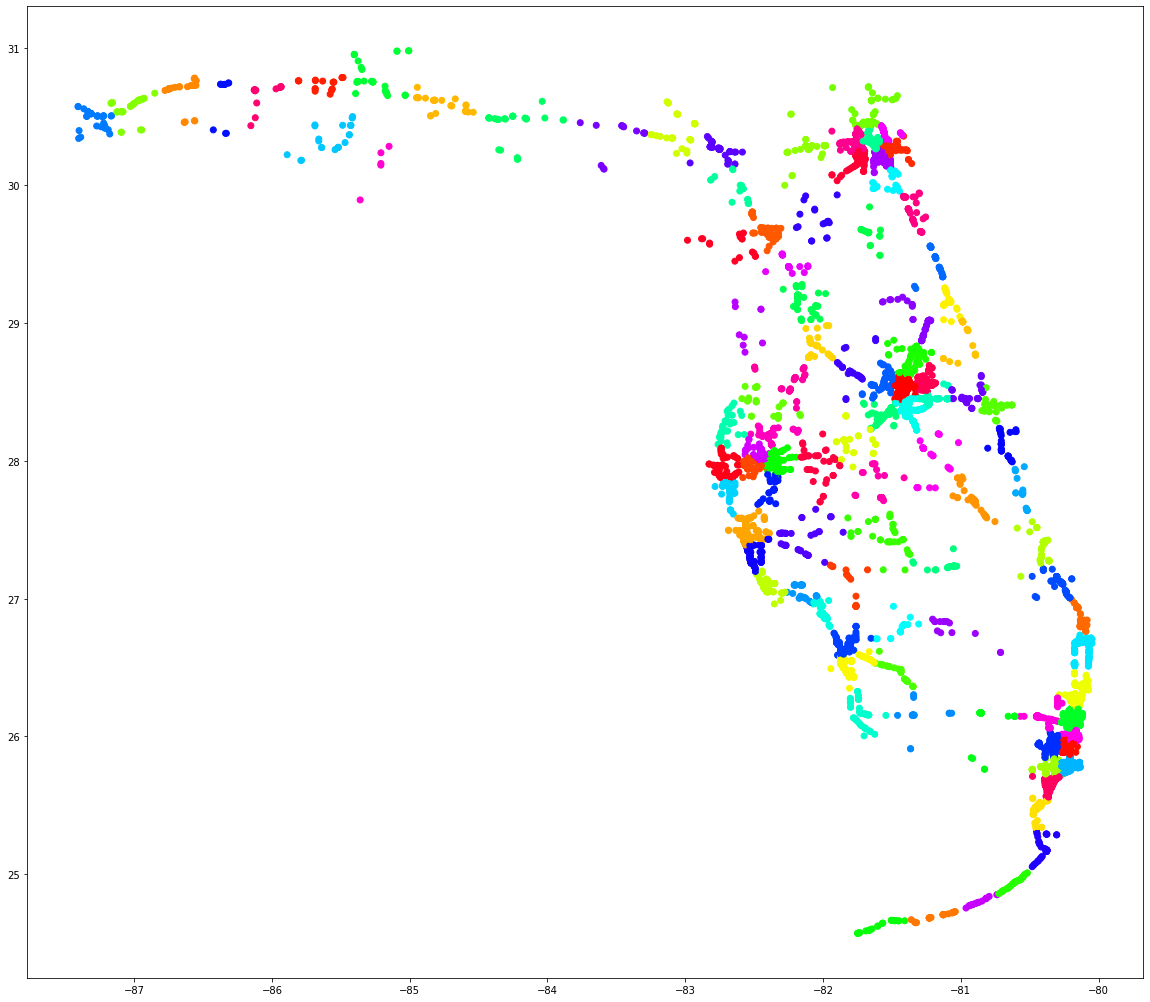

In [0]:
fl_gdf2.plot(column='cluster', cmap= 'hsv', figsize=(20,22))

In [0]:
xc=np.array(df_floridatrain['Start_Lng'])
yc=np.array(df_floridatrain['Start_Lat'])
print(xc.shape)
print(yc.shape)
ctest=np.array(df_floridatrain['cluster'])
print(ctest.shape)

(7422,)
(7422,)
(7422,)


In [0]:
centroids=kmeans.cluster_centers_[ctest]
print(centroids)

[[ 25.80259072 -80.20833914]
 [ 25.80259072 -80.20833914]
 [ 27.3137745  -82.48840961]
 ...
 [ 27.96078798 -82.49972445]
 [ 28.56897554 -81.25421824]
 [ 25.92388483 -80.20696847]]


In [0]:
centroids.shape

(7422, 2)

In [0]:
df_centroids=pd.DataFrame(data=centroids)
df_centroids=df_centroids.rename(columns={0: 'Lat', 1: 'Lng'})

In [0]:
df_centroids.head()

,Lat,Lng
0,25.802591,-80.208339
1,25.802591,-80.208339
2,27.313775,-82.488410
3,25.995426,-80.169881
4,27.960788,-82.499724


In [0]:
def create_gdf2(df_centroids, lat, lon):
    """ Convert pandas dataframe into a Geopandas GeoDataFrame"""
    crs = {'init': 'epsg:4326'}
    geometry = [Point(xy) for xy in zip(df_centroids['Lng'], df_centroids['Lat'])]
    gdf3 = gpd.GeoDataFrame(df_centroids, crs= crs , geometry=geometry)
    return gdf3
fl_gdf4 =  create_gdf2(df_centroids, "latitude", "longitude")
fl_gdf4.tail()

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


,Lat,Lng,geometry
7417,27.707273,-80.906707,POINT (-80.90671 27.70727)
7418,30.401256,-83.050414,POINT (-83.05041 30.40126)
7419,27.960788,-82.499724,POINT (-82.49972 27.96079)
7420,28.568976,-81.254218,POINT (-81.25422 28.56898)
7421,25.923885,-80.206968,POINT (-80.20697 25.92388)


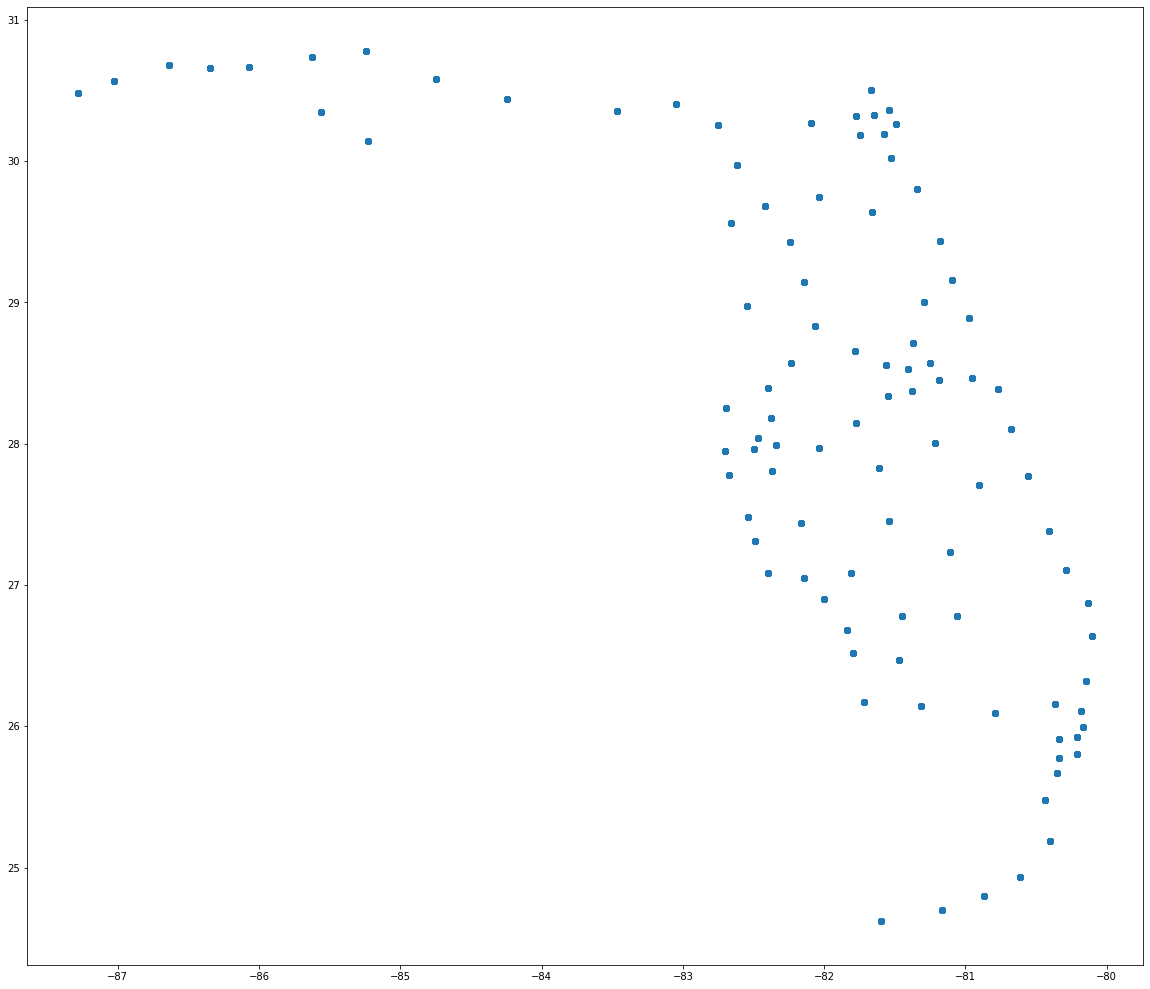

In [0]:
fl_gdf4.plot(figsize=(20,22))

Now that we have conducted preliminary analysis of the data and have found a target variable of severity and locations let's use K nearest neighbor clustering to predict problem areas that need attention.

In [0]:
"""
from shapely.ops import nearest_points

gdf['nearestpoints']=nearest_points(gdf['geometry'], gdf['centroid'],)
"""

"\nfrom shapely.ops import nearest_points\n\ngdf['nearestpoints']=nearest_points(gdf['geometry'], gdf['centroid'],)\n"

Let's try a new tactic to conduct KNN. So now we will check to see if location increases any type of severity and where to place officials to address accidents efficiently.

In [0]:
df_florida=df_traffic.loc[(df_traffic['State']=='FL')][['ID', 'Start_Lng', 'Start_Lat', 'Severity']]
df_florida.tail()

,ID,Start_Lng,Start_Lat,Severity
time,,,,
2019-08-23 14:16:20,A-2974027,-80.10460,26.84352,2
2019-08-23 14:12:39,A-2974028,-81.15644,29.40633,3
2019-08-23 17:28:24,A-2974033,-82.44727,27.96509,4
2019-08-23 19:51:27,A-2974038,-81.27017,28.54708,4
2019-08-23 19:14:05,A-2974039,-80.19918,25.93595,4


In [0]:
X=pd.concat([df_florida['Start_Lat'],df_florida['Start_Lng']],axis=1)
X.head()

,Start_Lat,Start_Lng
time,,
2016-11-30 15:36:03,27.981367,-82.326561
2016-11-30 16:25:35,27.981367,-82.326561
2016-11-30 16:40:31,25.627699,-80.374451
2016-11-30 16:34:57,25.899435,-80.346680
2016-11-30 16:38:41,26.272926,-80.296432


In [0]:
X.shape

(223746, 2)

In [0]:
y=df_florida['Severity']
y.head()

time
2016-11-30 15:36:03    3
2016-11-30 16:25:35    3
2016-11-30 16:40:31    2
2016-11-30 16:34:57    3
2016-11-30 16:38:41    2
Name: Severity, dtype: int64

In [0]:
y.shape

(223746,)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)


In [0]:
y_train.shape

(178996,)

In [0]:
"""
What KNN is doing when called

def euclid_distance(x1, x2):
  np.sqrt(np.sum((x1-x)**2))

class KNN:
  def euclidean_distance(x1, x2):
    return np.sqrt(np.sum(()))
  def Manhattan Distance()

  def __init__(self, k=100):
    self.k = k

  def fit(self, X, y):
    self.X_train = X
    self.y_train = y

  def predict(self, X):
    #compute distances
    predicted_labels = [self._predict(x) for x in X]
    return 
    
  def _predict(self, x):
    #compute distance
    distances = [euclidean_distance(X, X_train) for X_train in self.X_train]
    #get K nearest samples, labels
    k_indices= np.argsort(distances)[:self.k]
    k_nearest_labels = [self.y_train[i] for i in k_indices]
"""

'\nWhat KNN is doing when called\n\ndef euclid_distance(x1, x2):\n  np.sqrt(np.sum((x1-x)**2))\n\nclass KNN:\n  def euclidean_distance(x1, x2):\n    return np.sqrt(np.sum(()))\n  def Manhattan Distance()\n\n  def __init__(self, k=100):\n    self.k = k\n\n  def fit(self, X, y):\n    self.X_train = X\n    self.y_train = y\n\n  def predict(self, X):\n    #compute distances\n    predicted_labels = [self._predict(x) for x in X]\n    return \n    \n  def _predict(self, x):\n    #compute distance\n    distances = [euclidean_distance(X, X_train) for X_train in self.X_train]\n    #get K nearest samples, labels\n    k_indices= np.argsort(distances)[:self.k]\n    k_nearest_labels = [self.y_train[i] for i in k_indices]\n'

In [0]:
accidentneighbors = KNeighborsClassifier(n_neighbors=100)
accidentneighbors.fit(X_train, y_train)
predictions = accidentneighbors.predict(X_test)

In [0]:
accuracy=np.sum(predictions == y_test) / len(y_test)
print(accuracy)

0.8094301675977653


Now that I have obtained the accuracy and loss of data that this model takes in for Florida, I will now try it for Arizona. I will run KNN for Arizona and California as well. I would like to potentially see if google collab will allow me to test the entirety of the United states as well. I would like to test out coordinates of an accident site to see if the model can accurately predict the severity of the accident.

In [0]:
df_arizona=df_traffic.loc[df_traffic['State']=='AZ'][['ID', 'Start_Lat', 'Start_Lng', 'Severity']]
df_arizona.head()

,ID,Start_Lat,Start_Lng,Severity
time,,,,
2019-12-24 23:36:25,A-512575,33.445259,-111.856468,2
2019-12-24 23:48:13,A-512576,35.264706,-112.049538,3
2019-12-25 04:32:47,A-512577,33.622849,-111.927834,2
2019-12-25 07:30:49,A-512578,33.503201,-112.043671,2
2019-12-25 09:06:59,A-512579,33.287281,-111.859009,2


In [0]:
X2=pd.concat([df_arizona['Start_Lat'],df_arizona['Start_Lng']],axis=1)
X2.shape
X2.head

<bound method NDFrame.head of                      Start_Lat   Start_Lng
time                                      
2019-12-24 23:36:25  33.445259 -111.856468
2019-12-24 23:48:13  35.264706 -112.049538
2019-12-25 04:32:47  33.622849 -111.927834
2019-12-25 07:30:49  33.503201 -112.043671
2019-12-25 09:06:59  33.287281 -111.859009
...                        ...         ...
2019-08-23 16:55:55  33.504990 -112.112570
2019-08-23 18:25:05  33.668760 -112.072750
2019-08-23 18:17:28  33.485120 -112.264000
2019-08-23 19:22:48  33.378330 -111.893270
2019-08-23 19:15:18  32.266400 -111.007310

[62330 rows x 2 columns]>

In [0]:
y2=df_arizona['Severity']
y2.shape
y2.head

<bound method NDFrame.head of time
2019-12-24 23:36:25    2
2019-12-24 23:48:13    3
2019-12-25 04:32:47    2
2019-12-25 07:30:49    2
2019-12-25 09:06:59    2
                      ..
2019-08-23 16:55:55    2
2019-08-23 18:25:05    2
2019-08-23 18:17:28    2
2019-08-23 19:22:48    2
2019-08-23 19:15:18    2
Name: Severity, Length: 62330, dtype: int64>

In [0]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=101)

In [0]:
accidentneighbors2 = KNeighborsClassifier(n_neighbors=100)
accidentneighbors2.fit(X2_train, y2_train)
predictions2 = accidentneighbors2.predict(X2_test)

In [0]:
accuracy2=np.sum(predictions2 == y2_test) / len(y2_test)
print(accuracy2)

0.8065939355045725


In [0]:
df_california=df_traffic.loc[(df_traffic['State']=='CA')][['ID', 'Start_Lng', 'Start_Lat', 'Severity']]
df_california.tail()

,ID,Start_Lng,Start_Lat,Severity
time,,,,
2019-08-23 18:03:25,A-2974354,-117.37936,34.00248,2
2019-08-23 19:11:30,A-2974355,-117.14806,32.76696,2
2019-08-23 19:00:21,A-2974356,-117.84779,33.77545,2
2019-08-23 19:00:21,A-2974357,-118.40302,33.99246,2
2019-08-23 18:52:06,A-2974358,-117.23092,34.13393,2


In [0]:
X3=pd.concat([df_california['Start_Lng'], df_california['Start_Lat']], axis=1)
X3.shape

(663204, 2)

In [0]:
y3=df_california['Severity']
y3.shape

(663204,)

In [0]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=102)

In [0]:
accidentneighbors3 = KNeighborsClassifier(n_neighbors=100)
accidentneighbors3.fit(X3_train, y3_train)
predictions3 = accidentneighbors3.predict(X3_test)

In [0]:
accuracy3=np.sum(predictions3 == y3_test) / len(y3_test)
print(accuracy3)

0.79472410491477


Now let's attempt this for 49 States not including Alaska or Hawaii and see if we can iterate through

In [0]:
df_us=df_traffic[['ID', 'Start_Lng', 'Start_Lat', 'Severity']]
df_us.tail()


,ID,Start_Lng,Start_Lat,Severity
2974330,A-2974354,-117.37936,34.00248,2
2974331,A-2974355,-117.14806,32.76696,2
2974332,A-2974356,-117.84779,33.77545,2
2974333,A-2974357,-118.40302,33.99246,2
2974334,A-2974358,-117.23092,34.13393,2


In [0]:
df_us.shape

(2974335, 4)

In [0]:
Xf=pd.concat([df_us['Start_Lng'], df_us['Start_Lat']], axis=1)
Xf.shape

(2974335, 2)

In [0]:
yf=df_us['Severity']
yf.shape

(2974335,)

In [0]:
Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, yf, train_size=0.8, random_state=1)

In [0]:
yf_train.value_counts()

2    1594617
3     710382
4      73677
1        792
Name: Severity, dtype: int64

For this test, let's use manhattan distance since longitude and latitude go east to west, north to south. And we will start with 10 neighbors for each State.

In [0]:
accidentneighborsf = KNeighborsClassifier(n_neighbors=490, p=1)
accidentneighborsf.fit(Xf_train, yf_train)
predictionsf = accidentneighborsf.predict(Xf_test)

In [0]:
accuracyf=np.sum(predictionsf == yf_test) / len(yf_test)
print(accuracyf)

0.7530405956289389


In [0]:
accidentneighborsf = KNeighborsClassifier(n_neighbors=500, p=1)
accidentneighborsf.fit(Xf_train, yf_train)
predictionsf = accidentneighborsf.predict(Xf_test)
accuracyf=np.sum(predictionsf == yf_test) / len(yf_test)
print(accuracyf)

0.7528405509130612


In [0]:
accidentneighborsf = KNeighborsClassifier(n_neighbors=450, p=1)
accidentneighborsf.fit(Xf_train, yf_train)
predictionsf = accidentneighborsf.predict(Xf_test)
accuracyf=np.sum(predictionsf == yf_test) / len(yf_test)
print(accuracyf)

0.7549469040978908


In [0]:
accidentneighborsf = KNeighborsClassifier(n_neighbors=400, p=1)
accidentneighborsf.fit(Xf_train, yf_train)
predictionsf = accidentneighborsf.predict(Xf_test)
accuracyf=np.sum(predictionsf == yf_test) / len(yf_test)
print(accuracyf)

0.7576113652295388


In [0]:
accidentneighborsf = KNeighborsClassifier(n_neighbors=430, p=1)
accidentneighborsf.fit(Xf_train, yf_train)
predictionsf = accidentneighborsf.predict(Xf_test)
accuracyf=np.sum(predictionsf == yf_test) / len(yf_test)
print(accuracyf)

0.7555672108219148


In [0]:
df_bad=df_traffic.loc[(df_traffic['Severity']==4)][['ID', 'Start_Lng', 'Start_Lat', 'Severity']]

In [0]:
kmean = KMeans(n_clusters=490)
clusters = kmean.fit_predict(df_bad[['Start_Lat','Start_Lng']])

In [0]:
df_bad['cluster'] = kmean.predict(df_bad[['Start_Lat','Start_Lng']])
df_bad.shape

(92337, 5)

In [0]:
df_bad.head()

,ID,Start_Lng,Start_Lat,Severity,cluster
time,,,,,
2016-03-11 13:18:48,A-620,-83.014236,39.917412,4,14
2016-06-24 22:28:49,A-1198,-121.899887,37.321117,4,45
2016-07-01 14:09:13,A-1902,-122.435043,37.630623,4,283
2016-07-25 14:23:33,A-4144,-121.851807,37.339115,4,45
2016-08-01 07:44:37,A-4965,-122.166687,37.710648,4,283


In [0]:
xu=np.array(df_bad['Start_Lng'])
yu=np.array(df_bad['Start_Lat'])
print(xu.shape)
print(yu.shape)
ctestu=np.array(df_bad['cluster'])
print(ctestu.shape)

(92337,)
(92337,)
(92337,)


In [0]:
centroidsu=kmean.cluster_centers_[ctestu]
print(centroidsu)

[[  39.94996281  -83.00013829]
 [  37.38930683 -121.98467632]
 [  37.70314328 -122.27080473]
 ...
 [  33.92122192 -117.8865182 ]
 [  33.92122192 -117.8865182 ]
 [  33.92122192 -117.8865182 ]]


In [0]:
print(centroidsu[0])
print(centroidsu.shape)

[ 39.94996281 -83.00013829]
(92337, 2)


In [0]:
df_centroidsu = pd.DataFrame(data=centroidsu, columns=['Lat', 'Lng'])
df_centroidsu.head()

,Lat,Lng
0,39.949963,-83.000138
1,37.389307,-121.984676
2,37.703143,-122.270805
3,37.389307,-121.984676
4,37.703143,-122.270805


In [0]:
def create_gdfu(df_centroidsu, lat, lon):
    """ Convert pandas dataframe into a Geopandas GeoDataFrame"""
    crs = {'init': 'epsg:4326'}
    geometry = [Point(xy) for xy in zip(df_centroidsu['Lng'], df_centroidsu['Lat'])]
    gdfu = gpd.GeoDataFrame(df_centroidsu, crs= crs , geometry=geometry)
    return gdfu
us_gdf =  create_gdfu(df_centroidsu, "latitude", "longitude")
us_gdf.tail()

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


,Lat,Lng,geometry
92332,38.630307,-121.423365,POINT (-121.42336 38.63031)
92333,38.630307,-121.423365,POINT (-121.42336 38.63031)
92334,33.921222,-117.886518,POINT (-117.88652 33.92122)
92335,33.921222,-117.886518,POINT (-117.88652 33.92122)
92336,33.921222,-117.886518,POINT (-117.88652 33.92122)


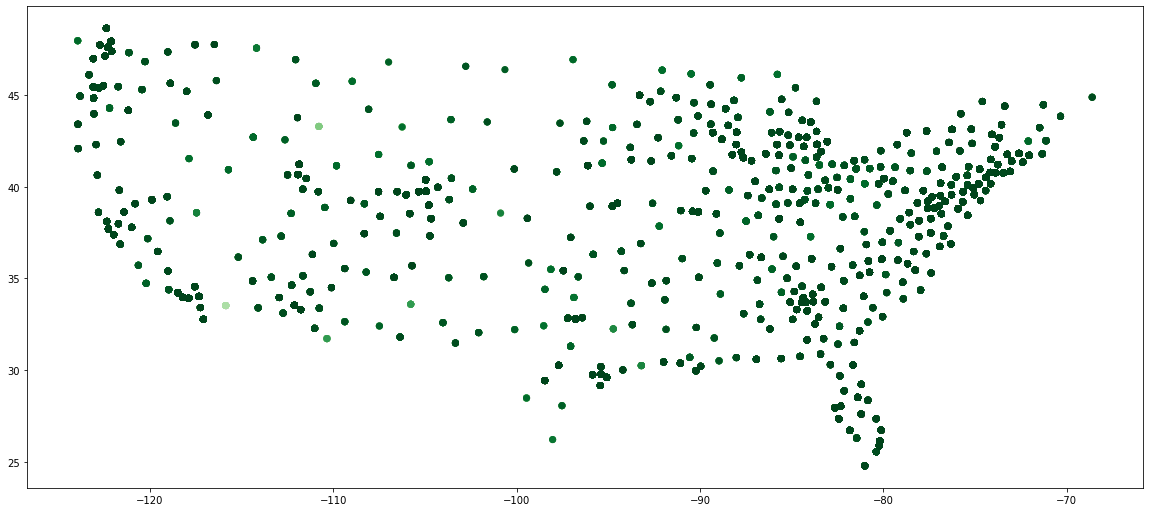

In [0]:
us_gdf.plot(cmap= 'Greens', figsize=(20,20))

In [0]:
"""for geocoding, a great example"""
geolocator = Nominatim(user_agent="specify_your_app_name_here")
location = geolocator.geocode("12702 Bruce B Downs Blvd, Tampa, FL 33612")
print(location.address)
print((location.longitude, location.latitude))

Bruce B Downs Boulevard, Tampa, Hillsborough County, Florida, 33620, United States of America
(-82.4079436, 28.088122)


In [0]:
accidentneighborsf = KNeighborsClassifier(n_neighbors=490, weights= 'distance', p=1, leaf_size=60, algorithm='auto')
accidentneighborsf.fit(Xf_train, yf_train)
predictionsf = accidentneighborsf.predict(Xf_test)
print(accuracy_score(yf_test, predictionsf))
print(classification_report(yf_test, predictionsf))
print(confusion_matrix(yf_test, predictionsf))


0.8556937937387685
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       176
           2       0.90      0.90      0.90    398793
           3       0.77      0.83      0.80    177238
           4       0.58      0.24      0.34     18660

    accuracy                           0.86    594867
   macro avg       0.56      0.49      0.51    594867
weighted avg       0.85      0.86      0.85    594867

[[     0    137     38      1]
 [    34 357855  38609   2295]
 [     2  29645 146754    837]
 [     0   9975   4270   4415]]


In [0]:
yf_test.value_counts()

2    398793
3    177238
4     18660
1       176
Name: Severity, dtype: int64

It looks like the category 2 accidents are overrepresented while severity 3, 4 accidents are exceptionally important to get true positives on. Therefore I will try use oversampling of severity 4 accidents or possibly undersampling of severity 2 accidents. I will first attempt to use SMOTE.

In [0]:
Xult=pd.concat([df_us['Start_Lng'], df_us['Start_Lat']], axis=1)

In [0]:
yult=yf=df_us['Severity']

In [0]:
sm = SMOTE(k_neighbors=10, random_state = 33)

In [0]:
Xult_train_new, yult_train_new = sm.fit_resample(Xult, yult)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
sm.get_params
Xult_train_new.shape
yult_train_new.shape

(7973640,)

In [0]:
Xult_trains, Xult_tests, yult_trains, yult_tests = train_test_split(Xult_train_new, yult_train_new, test_size = 0.3, random_state = 33, shuffle = True)

In [0]:
clf= KNeighborsClassifier(n_neighbors=150, weights= 'distance', p=1, leaf_size=60, algorithm='auto')

In [0]:
clf.fit(Xult_trains, yult_trains)
predsm = clf.predict(Xult_tests)
print(accuracy_score(yult_tests, predsm))
print(classification_report(yult_tests, predsm))
print(confusion_matrix(yult_tests, predsm))

0.8306319322166539
              precision    recall  f1-score   support

           1       0.93      0.88      0.90    597249
           2       0.80      0.80      0.80    598471
           3       0.76      0.88      0.82    597624
           4       0.86      0.77      0.81    598748

    accuracy                           0.83   2392092
   macro avg       0.84      0.83      0.83   2392092
weighted avg       0.84      0.83      0.83   2392092

[[524375  31542  21869  19463]
 [ 20932 477421  67025  33093]
 [  3420  44343 524547  25314]
 [ 17884  44375  75884 460605]]


In [0]:
saved_model=pickle.dumps(clf)

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html

This explains sklearn's Distance Metric parameter

https://medium.com/datadriveninvestor/k-nearest-neighbors-knn-7b4bd0128da7

This article explains K nearest neighbor.

https://towardsdatascience.com/nearest-neighbour-analysis-with-geospatial-data-7bcd95f34c0e

This article assists with implementing k nearest neighbor for geo spatial data.

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.kneighbors

This explains KNearest Neighbor from sklearn.

https://medium.com/datadriveninvestor/k-fold-and-other-cross-validation-techniques-6c03a2563f1e

This article explains evaluation of K nearest neighbor.

Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, and Rajiv Ramnath. “A Countrywide Traffic Accident Dataset.”, 2019.

Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, Radu Teodorescu, and Rajiv Ramnath. "Accident Risk Prediction based on Heterogeneous Sparse Data: New Dataset and Insights." In proceedings of the 27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, ACM, 2019.